In [2]:
import numpy as np
import os
# import png
import torch
from tqdm import tqdm
from torch.utils.data.dataset import Dataset
from PIL import Image

In [3]:
!pip install pypng

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
data_path = '/content/drive/MyDrive/Temp/part3/'

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [7]:
class FacadeDataset(Dataset):
    def __init__(self, flag, dataDir=data_path+'starter_set/', data_range=(0, 8), n_class=5, onehot=False):
        self.onehot = onehot
        assert(flag in ['train', 'eval', 'test', 'test_dev', 'kaggle'])
        print("load "+ flag+" dataset start")
        print("    from: %s" % dataDir)
        print("    range: [%d, %d)" % (data_range[0], data_range[1]))
        self.dataset = []
        for i in range(data_range[0], data_range[1]):
            img = Image.open(os.path.join(dataDir,flag,'eecs442_%04d.jpg' % i))

            pngreader = png.Reader(filename=os.path.join(dataDir,flag,'eecs442_%04d.png' % i))
            w,h,row,info = pngreader.read()
            label = np.array(list(row)).astype('uint8')

            # Normalize input image
            img = np.asarray(img).astype("f").transpose(2, 0, 1)/128.0-1.0
            # Convert to n_class-dimensional onehot matrix
            label_ = np.asarray(label)
            label = np.zeros((n_class, img.shape[1], img.shape[2])).astype("i")
            for j in range(n_class):
                label[j, :] = label_ == j
            self.dataset.append((img, label))
        print("load dataset done")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, label = self.dataset[index]
        label = torch.FloatTensor(label)
        if not self.onehot:
            label = torch.argmax(label, dim=0)
        else:
            label = label.long()

        return torch.FloatTensor(img), torch.LongTensor(label)


In [8]:
!pip install colormap

In [9]:
!pip install easydev

In [10]:
import os
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import png
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from colormap.colors import Color, hex2rgb
from sklearn.metrics import average_precision_score as ap_score
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from tqdm import tqdm

# from dataset import FacadeDataset

N_CLASS=5

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.n_class = N_CLASS
        self.layers = nn.Sequential(
            #########################################
            ###        TODO: Add more layers      ###
            #########################################
            nn.Conv2d(3, self.n_class, 1, padding=0),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

def save_label(label, path):
    '''
    Function for ploting labels.
    '''
    colormap = [
        '#000000',
        '#0080FF',
        '#80FF80',
        '#FF8000',
        '#FF0000',
    ]
    assert(np.max(label)<len(colormap))
    colors = [hex2rgb(color, normalise=False) for color in colormap]
    w = png.Writer(label.shape[1], label.shape[0], palette=colors, bitdepth=4)
    with open(path, 'wb') as f:
        w.write(f, label)

def train(trainloader, net, criterion, optimizer, device, epoch):
    '''
    Function for training.
    '''
    start = time.time()
    running_loss = 0.0
    net = net.train()
    tr_losses = []
    for images, labels in tqdm(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss = loss.item()
        tr_losses.append(running_loss)
    end = time.time()
    print('[epoch %d] loss: %.3f elapsed time %.3f' %
          (epoch, running_loss, end-start))
    return np.array(tr_losses).mean()

def test(testloader, net, criterion, device):
    '''
    Function for testing.
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            loss = criterion(output, labels)
            losses += loss.item()
            cnt += 1
    print(losses / cnt)
    return (losses/cnt)


def cal_AP(testloader, net, criterion, device):
    '''
    Calculate Average Precision
    '''
    losses = 0.
    cnt = 0
    with torch.no_grad():
        net = net.eval()
        preds = [[] for _ in range(5)]
        heatmaps = [[] for _ in range(5)]
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images).cpu().numpy()
            for c in range(5):
                preds[c].append(output[:, c].reshape(-1))
                heatmaps[c].append(labels[:, c].cpu().numpy().reshape(-1))

        aps = []
        for c in range(5):
            preds[c] = np.concatenate(preds[c])
            heatmaps[c] = np.concatenate(heatmaps[c])
            if heatmaps[c].max() == 0:
                ap = float('nan')
            else:
                ap = ap_score(heatmaps[c], preds[c])
                aps.append(ap)
            print("AP = {}".format(ap))

    # print(losses / cnt)
    return None


def get_result(testloader, net, device, folder=data_path+'output_train'):
    result = []
    cnt = 1
    with torch.no_grad():
        net = net.eval()
        cnt = 0
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)[0].cpu().numpy()
            c, h, w = output.shape
            assert(c == N_CLASS)
            y = np.zeros((h,w)).astype('uint8')
            for i in range(N_CLASS):
                mask = output[i]>0.5
                y[mask] = i
            gt = labels.cpu().data.numpy().squeeze(0).astype('uint8')
            save_label(y, '/{}/y{}.png'.format(folder, cnt))
            save_label(gt, '/{}/gt{}.png'.format(folder, cnt))
            plt.imsave(
                '/{}/x{}.png'.format(folder, cnt),
                ((images[0].cpu().data.numpy()+1)*128).astype(np.uint8).transpose(1,2,0))

            cnt += 1



In [46]:
def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # TODO change data_range to include all train/evaluation/test data.
    # TODO adjust batch_size.
    train_data = FacadeDataset(flag='train', data_range=(0,250), onehot=False)
    train_loader = DataLoader(train_data, batch_size=1)
    val_data = FacadeDataset(flag='train', data_range=(250,350), onehot=False)
    val_loader = DataLoader(val_data, batch_size=1)
    test_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=False)
    test_loader = DataLoader(test_data, batch_size=1)
    ap_data = FacadeDataset(flag='test_dev', data_range=(0,114), onehot=True)
    ap_loader = DataLoader(ap_data, batch_size=1)

    name = 'starter_net'
    # net = Net().to(device)
    net = UNet(n_channels=3, n_classes=5, bilinear=True).to(device)
    criterion = nn.CrossEntropyLoss() #TODO decide loss
    optimizer = torch.optim.Adam(net.parameters(), 1e-3, weight_decay=1e-4)

    print('\nStart training')
    tr_loss, vl_loss = [], [] 
    for epoch in range(10): #TODO decide epochs
        print('-----------------Epoch = %d-----------------' % (epoch+1))
        tr_loss.append(train(train_loader, net, criterion, optimizer, device, epoch+1))
        # TODO create your evaluation set, load the evaluation set and test on evaluation set
        evaluation_loader = val_loader
        vl_loss.append(test(evaluation_loader, net, criterion, device))

    print('\nFinished Training, Testing on test set')
    test(test_loader, net, criterion, device)
    print('\nGenerating Unlabeled Result')
    result = get_result(test_loader, net, device, folder=data_path+'output_test')

    torch.save(net.state_dict(), data_path+'models/model_{}.pth'.format(name))

    cal_AP(ap_loader, net, criterion, device)

    return tr_loss, vl_loss



In [47]:
torch.cuda.empty_cache()

In [48]:
tr, vl = main()

load train dataset start
    from: /content/drive/MyDrive/Temp/part3/starter_set/
    range: [0, 250)
load dataset done
load train dataset start
    from: /content/drive/MyDrive/Temp/part3/starter_set/
    range: [250, 350)
load dataset done
load test_dev dataset start
    from: /content/drive/MyDrive/Temp/part3/starter_set/
    range: [0, 114)
load dataset done
load test_dev dataset start
    from: /content/drive/MyDrive/Temp/part3/starter_set/
    range: [0, 114)
load dataset done

Start training
-----------------Epoch = 1-----------------


100%|██████████| 250/250 [01:02<00:00,  3.99it/s]


[epoch 1] loss: 0.998 elapsed time 62.722


100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


0.9899631455540657
-----------------Epoch = 2-----------------


100%|██████████| 250/250 [01:02<00:00,  4.00it/s]


[epoch 2] loss: 0.952 elapsed time 62.433


100%|██████████| 100/100 [00:09<00:00, 10.37it/s]


0.974993286728859
-----------------Epoch = 3-----------------


100%|██████████| 250/250 [01:02<00:00,  4.02it/s]


[epoch 3] loss: 0.945 elapsed time 62.283


100%|██████████| 100/100 [00:09<00:00, 10.40it/s]


0.9238777554035187
-----------------Epoch = 4-----------------


100%|██████████| 250/250 [01:02<00:00,  4.02it/s]


[epoch 4] loss: 0.913 elapsed time 62.254


100%|██████████| 100/100 [00:09<00:00, 10.38it/s]


0.9025704926252365
-----------------Epoch = 5-----------------


100%|██████████| 250/250 [01:02<00:00,  4.02it/s]


[epoch 5] loss: 0.933 elapsed time 62.245


100%|██████████| 100/100 [00:09<00:00, 10.25it/s]


0.9038743925094604
-----------------Epoch = 6-----------------


100%|██████████| 250/250 [01:02<00:00,  4.00it/s]


[epoch 6] loss: 0.892 elapsed time 62.529


100%|██████████| 100/100 [00:09<00:00, 10.30it/s]


0.879804105758667
-----------------Epoch = 7-----------------


100%|██████████| 250/250 [01:02<00:00,  4.01it/s]


[epoch 7] loss: 0.915 elapsed time 62.393


100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


0.8886627447605133
-----------------Epoch = 8-----------------


100%|██████████| 250/250 [01:02<00:00,  4.02it/s]


[epoch 8] loss: 0.896 elapsed time 62.168


100%|██████████| 100/100 [00:09<00:00, 10.40it/s]


0.874065312743187
-----------------Epoch = 9-----------------


100%|██████████| 250/250 [01:02<00:00,  3.99it/s]


[epoch 9] loss: 0.933 elapsed time 62.647


100%|██████████| 100/100 [00:09<00:00, 10.24it/s]


0.8624440297484398
-----------------Epoch = 10-----------------


100%|██████████| 250/250 [01:02<00:00,  4.00it/s]


[epoch 10] loss: 0.944 elapsed time 62.459


100%|██████████| 100/100 [00:09<00:00, 10.41it/s]


0.8529533696174622

Finished Training, Testing on test set


100%|██████████| 114/114 [00:10<00:00, 10.37it/s]


0.8375245915693149

Generating Unlabeled Result


100%|██████████| 114/114 [00:10<00:00, 11.32it/s]


AP = 0.6089238893672273
AP = 0.7210995855695945
AP = 0.10109873775361533
AP = 0.8375094023239443
AP = 0.4932065963752939


In [53]:
AP = (.608+.721+.101+.8375+.4932)/5
print("Avergae AP =", AP)

Avergae AP = 0.55214


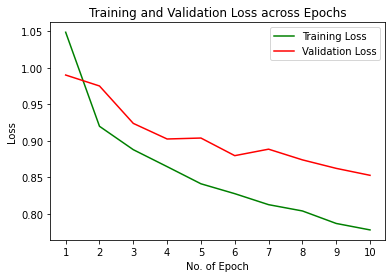

In [54]:
import math 
x = np.arange(1, 10+1, 1)
x = range(math.floor(min(x)), math.ceil(max(x))+1)
plt.xticks(x)
plt.plot(x, tr, "-g", label="Training Loss")
plt.plot(x, vl, "-r", label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("No. of Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss across Epochs")
plt.show()

In [55]:
AP

0.55214

In [58]:
model = UNet(n_channels=3, n_classes=5, bilinear=True)
model.load_state_dict(torch.load(data_path+'models/model_starter_net.pth'))
model.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment